# Fitting Tree Based Models

In [1]:
# Import the modules made for feature imputation/engineering/selection
import sys
sys.path.insert(0,'..')
import FeatureEngineering_Module as fe
import Imputation_Module as imp
import Encoding_Module as ec

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)
sns.set(style = "whitegrid")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import joblib

In [3]:
train_df, test_df = imp.impute_data()
train = fe.FeatureEngineering(train_df)
test = fe.FeatureEngineering(test_df)

In [4]:
train, test = ec.encode(train, test)

In [5]:
# Isolating the target feature and applying log transformation for normality
Y = train["SalePrice"]
X = train.drop("SalePrice", axis = 1)

In [6]:
print("train shape: " + str(X.shape))
print("test shape: " + str(test.shape))

train shape: (1456, 49)
test shape: (1459, 49)


## Train/Test Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

## Random Forest

In [9]:
randomForest = RandomForestRegressor(random_state = 0)

In [10]:
grid_para_forest = {'n_estimators': [100,500,1000,2500,5000],
                   'max_depth': [10,15,20,30,40,50],
                   'max_features' : [5,7,15]}

In [11]:
grid_search_forest = GridSearchCV(randomForest, 
                                  grid_para_forest,
                                  cv=5, n_jobs = 5, verbose = 1)
grid_search_forest.fit(X_train, y_train)

print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)
print(grid_search_forest.best_estimator_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
/Users/hb/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:   18.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:  2.3min
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  6.0min
[Parallel(n_jobs=5)]: Done 450 out of 450 | elapsed:  6.4min finished


{'max_depth': 15, 'max_features': 15, 'n_estimators': 500}
0.8725556352769297
RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=15, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=500, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)


In [12]:
bestmodel_rf = grid_search_forest.best_estimator_
pred_rf = bestmodel_rf.predict(X_test)
RMSLE = np.sqrt(mean_squared_log_error(pred_rf, y_test))
print("RMSLE: " + str(round(RMSLE,5)))

RMSLE: 0.11693


In [13]:
# pickle the parameter
joblib.dump(bestmodel_rf, "grid_RF_params.pkl")

['grid_RF_params.pkl']

Text(0, 0.5, 'Features')

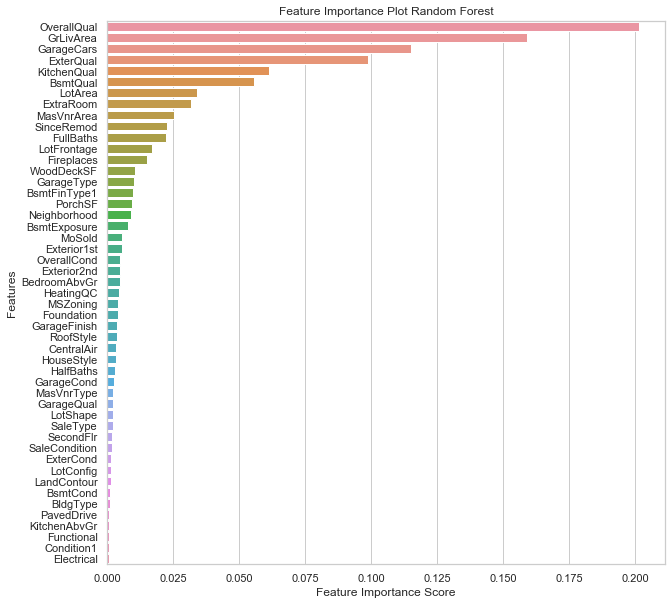

In [14]:
sorted_importance = sorted(zip(X.columns, bestmodel_rf.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Plot Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

Text(0, 0.5, 'Predicted Value')

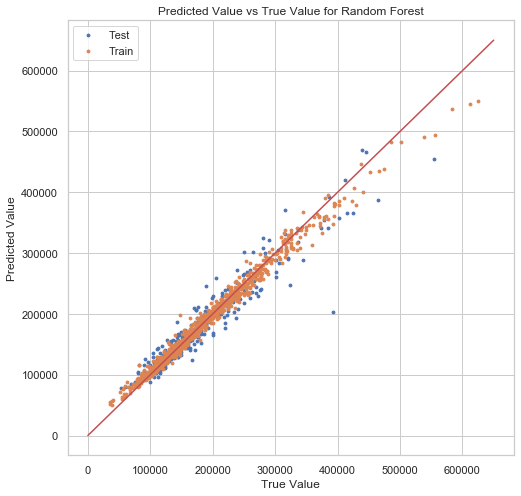

In [15]:
plt.figure(figsize=(8,8))
plt.scatter(x = y_test, y = pred_rf, s = 8, label = "Test")
plt.scatter(x = y_train, y = bestmodel_rf.predict(X_train), s = 8, label = "Train")
plt.plot([0,650000],[0,650000], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Random Forest")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

### Dropping the features with nearly no importance and re-fit Random Forest

In [16]:
imp_cols = df[df['importance_score'] > 0.004]['feature_name'].tolist()

In [ ]:
# grid_search_forest.fit(X_train[imp_cols], y_train)

# print(grid_search_forest.best_params_)
# print(grid_search_forest.best_score_)
# print(grid_search_forest.best_estimator_)
# bestmodel_rff = grid_search_forest.best_estimator_
# pred_rff = bestmodel_rff.predict(X_test[imp_cols])
# RMSLE = np.sqrt(mean_squared_log_error(pred_rff, y_test))
# print("RMSLE: " + str(round(RMSLE,5)))

## Gradient Boosting

In [8]:
gbm = GradientBoostingRegressor(random_state = 0)

In [9]:
grid_para_gb = {'n_estimators': [100,500,1000,2500,5000],
                   'learning_rate':[0.01,0.05,0.1],
                   'max_depth':range(1,6),
                   'max_features' : [5,7,15]}

In [10]:
grid_search_gb = GridSearchCV(gbm, grid_para_gb, cv=5, n_jobs = 5, verbose = 1)
grid_search_gb.fit(X_train, y_train)

print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    3.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   27.8s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:  1.5min
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  2.9min
[Parallel(n_jobs=5)]: Done 1125 out of 1125 | elapsed:  4.2min finished


{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 5, 'n_estimators': 5000}
0.9002020408969701
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


In [11]:
bestmodel_gb = grid_search_gb.best_estimator_
pred_gb = bestmodel_gb.predict(X_test)
RMSLE = np.sqrt(mean_squared_log_error(pred_gb, y_test))
RMSLE

0.10832739249414072

In [12]:
# pickle the parameter
joblib.dump(bestmodel_gb, "grid_GB_params.pkl")

['grid_GB_params.pkl']

Text(0, 0.5, 'Features')

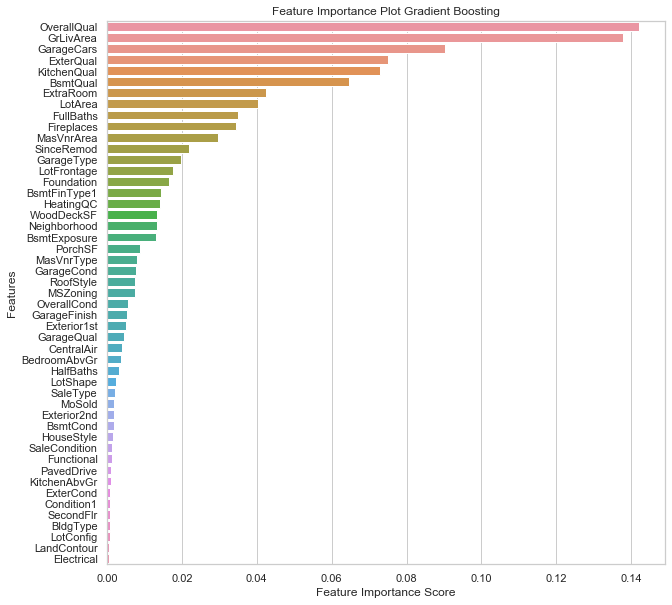

In [13]:
sorted_importance = sorted(zip(X.columns, bestmodel_gb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Plot Gradient Boosting')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')

Text(0, 0.5, 'Predicted Value')

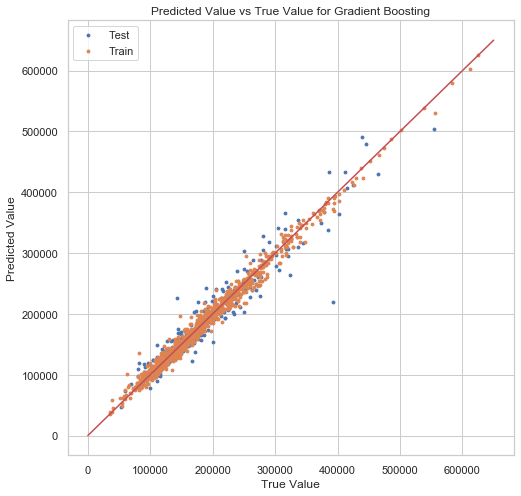

In [14]:
plt.figure(figsize=(8,8))
plt.scatter(x = y_test, y = pred_gb, s = 8, label = "Test")
plt.scatter(x = y_train, y = bestmodel_gb.predict(X_train), s = 8, label = "Train")
plt.plot([0,650000],[0,650000], color = "r")
plt.legend(loc = 0)
plt.title("Predicted Value vs True Value for Gradient Boosting")
plt.xlabel("True Value")
plt.ylabel("Predicted Value")

### Dropping the features with nearly no importance and re-fit Gradient Boosting

In [15]:
imp_cols = df[df['importance_score'] > 0.004]['feature_name'].tolist()

In [16]:
grid_search_gb.fit(X_train[imp_cols], y_train)

print(grid_search_gb.best_params_)
print(grid_search_gb.best_score_)
print(grid_search_gb.best_estimator_)
bestmodel_gbb = grid_search_gb.best_estimator_
pred_gbb = bestmodel_gbb.predict(X_test[imp_cols])
RMSLE = np.sqrt(mean_squared_log_error(pred_gbb, y_test))
RMSLE

Fitting 5 folds for each of 225 candidates, totalling 1125 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  65 tasks      | elapsed:    7.7s
[Parallel(n_jobs=5)]: Done 215 tasks      | elapsed:   37.4s
[Parallel(n_jobs=5)]: Done 465 tasks      | elapsed:  1.8min
[Parallel(n_jobs=5)]: Done 815 tasks      | elapsed:  3.4min
[Parallel(n_jobs=5)]: Done 1125 out of 1125 | elapsed:  4.9min finished


{'learning_rate': 0.01, 'max_depth': 3, 'max_features': 5, 'n_estimators': 5000}
0.8948495902911825
GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.01, loss='ls', max_depth=3,
                          max_features=5, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=5000,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


0.11349404922156364

Text(0, 0.5, 'Features')

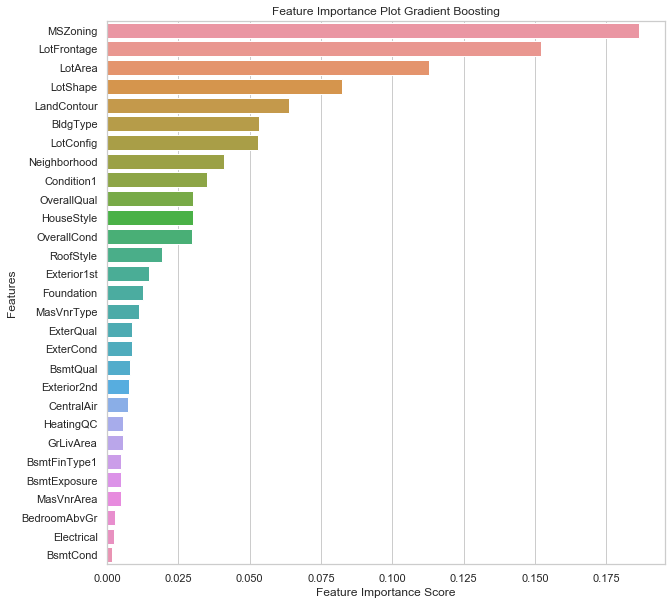

In [17]:
sorted_importance = sorted(zip(X.columns, bestmodel_gbb.feature_importances_), key=lambda t:t[1], reverse=True)
a, b = zip(*sorted_importance)
plt.figure(figsize = (10,10))
df = pd.DataFrame({'feature_name':a, 'importance_score':b})
sns.barplot(data = df, x = 'importance_score', y= 'feature_name', orient = 'h');
plt.title('Feature Importance Plot Gradient Boosting')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')